In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import *

# if dataset is in drive
#from google.colab import drive
#drive.mount(path := '/drive')
#path += '/MyDrive/MMA/dataset.csv'
# else
path = '../data/dataset.csv'

random_state = 42

In [2]:
df = pd.read_csv(path, low_memory=False).drop(['fight_id', 'f_1', 'f_2', 'finish_time'], axis=1)
df[:1]

,winner,weight_class,result,finish_round,knockdownsA,total_strikes_attA,total_strikes_succA,sig_strikes_attA,sig_strikes_succA,takedown_attA,...,sig_strikes_attB,sig_strikes_succB,takedown_attB,takedown_succB,submission_attB,reversalsB,ctrl_timeB,wins decB,wins subB,wins koB
0,0,2,0,2,0.000556,0.239795,0.161637,0.134006,0.066257,0.014064,...,0.175345,0.082486,0.000988,0.000988,0.0,0.0,0.040564,1,0,1


In [3]:
targets  = df[ts := ['winner', 'result', 'finish_round']]
features = df.drop(ts, axis=1)
targets.shape, features.shape

((2869, 3), (2869, 27))

In [4]:
# scaling the data

from sklearn.preprocessing import StandardScaler

to_scale = list(features.columns.copy())
to_scale = to_scale[1:11] + to_scale[14:-3]

features[to_scale] = StandardScaler().fit_transform(features[to_scale])
features[to_scale].describe()

,knockdownsA,total_strikes_attA,total_strikes_succA,sig_strikes_attA,sig_strikes_succA,takedown_attA,takedown_succA,submission_attA,reversalsA,ctrl_timeA,knockdownsB,total_strikes_attB,total_strikes_succB,sig_strikes_attB,sig_strikes_succB,takedown_attB,takedown_succB,submission_attB,reversalsB,ctrl_timeB
count,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03,2.869000e+03
mean,3.714932e-18,2.872881e-16,2.228959e-16,1.485973e-16,-3.962595e-17,1.981297e-17,6.439216e-17,-9.906486e-18,-9.906486e-18,3.962595e-17,-3.219608e-17,-2.724284e-16,3.962595e-17,1.485973e-16,9.906486e-18,-3.591101e-17,-7.677527e-17,-2.971946e-17,-9.906486e-18,-1.040181e-16
std,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00,1.000174e+00
min,-3.574645e-01,-1.348524e+00,-1.316888e+00,-1.338344e+00,-1.224460e+00,-7.727224e-01,-5.912066e-01,-4.794435e-01,-3.275308e-01,-7.939814e-01,-3.795282e-01,-1.008667e+00,-1.012732e+00,-1.019516e+00,-9.693069e-01,-7.158744e-01,-6.284348e-01,-4.796078e-01,-3.168375e-01,-8.310995e-01
25%,-3.574645e-01,-5.613921e-01,-5.528559e-01,-5.891232e-01,-5.787251e-01,-6.281010e-01,-5.912066e-01,-4.794435e-01,-3.275308e-01,-5.854658e-01,-3.795282e-01,-4.428327e-01,-4.378260e-01,-4.702086e-01,-4.691293e-01,-5.808265e-01,-6.284348e-01,-4.796078e-01,-3.168375e-01,-5.913396e-01
50%,-3.574645e-01,-2.232493e-01,-2.559682e-01,-2.242075e-01,-2.643603e-01,-2.665475e-01,-3.313792e-01,-4.794435e-01,-3.275308e-01,-2.463646e-01,-3.795282e-01,-2.012614e-01,-2.081751e-01,-2.099676e-01,-2.344781e-01,-2.432068e-01,-2.583698e-01,-4.796078e-01,-3.168375e-01,-2.271943e-01
75%,-6.870382e-02,2.139614e-01,2.055506e-01,2.706550e-01,2.019338e-01,2.855577e-01,1.882756e-01,9.430688e-02,-3.275308e-01,2.779433e-01,-4.280641e-02,1.369477e-01,1.405355e-01,1.850480e-01,1.474406e-01,2.515360e-01,2.153134e-01,1.079970e-01,-3.168375e-01,2.974650e-01
max,1.446559e+01,9.440787e+00,9.536884e+00,9.756162e+00,8.806134e+00,1.614798e+01,2.093735e+01,1.046963e+01,2.160956e+01,2.232228e+01,1.699532e+01,2.252877e+01,2.316793e+01,2.067658e+01,2.097612e+01,1.685000e+01,2.197196e+01,1.053798e+01,2.124448e+01,1.530904e+01


In [5]:
Xtrain, Ytrain = features[500:], targets[500:]
Xtest, Ytest   = features[:500], targets[:500]

Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((2369, 27), (2369, 3), (500, 27), (500, 3))

In [6]:
class MMADataset(Dataset):
    def __init__(self, features, targets):
        assert len(features) == len(targets)
        self.features = features
        self.targets  = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # first linear layer
        self.fc2 = nn.Linear(hidden_size, output_size) # second linear layer
        self.relu = nn.ReLU()                         # activation function
        self.softmax = nn.Softmax(dim=1)               # output activation function

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

def get_accuracy_dl(nn, dl):
    correct = total = 0
    for inputs, labels in dl:
        outputs = nn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train(nn, epochs, loss_func, optimizer, dataloader, test, print_interval=10):
    losses = []       # loss
    axs, axt = [], [] # accuracy

    xtest, ytest = test # testing set

    for epoch in range(epochs):

        # iterating over one batch
        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()

            # forward
            predictions = nn(inputs)
            loss = loss_func(predictions, labels)

            # backward
            loss.backward()
            optimizer.step()

        with torch.no_grad(): axs_ = get_accuracy_dl(nn, dl)
        axt_ = accuracy_score(ytest, nn(xtest).argmax(1)) * 100

        losses.append(loss.item())

        axs.append(axs_)
        axt.append(axt_)

        if (epoch+1) % print_interval == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Training: {axs_:.2f}%, Testing: {axt_:.2f}%')

    return losses, axs, axt

xs = torch.tensor(Xtrain.to_numpy()).float()
xt = torch.tensor(Xtest.to_numpy()).float()

input_size = len(xs[0])

# Predicting the winner (A or B)

In [7]:
target = 'winner'

output_size = 2

ys = torch.tensor(Ytrain[target].to_numpy())
yt = torch.tensor(Ytest[target].to_numpy())

ds = MMADataset(xs, ys)
dl = DataLoader(ds, batch_size=64, shuffle=False)

In [8]:
torch.manual_seed(random_state)

nn_winner = NN(
    input_size=input_size,
    hidden_size=20,
    output_size=output_size,
)

epochs    = 160
lossfunc  = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_winner.parameters(), lr=0.0001, weight_decay=0.001)

loss, axs, axt = train(nn_winner, epochs, lossfunc, optimizer, dl, (xt, yt), print_interval=10)

Epoch [10/160], Loss: 0.6066, Training: 51.54%, Testing: 46.60%
Epoch [20/160], Loss: 0.5960, Training: 53.69%, Testing: 50.60%
Epoch [30/160], Loss: 0.5783, Training: 56.23%, Testing: 52.60%
Epoch [40/160], Loss: 0.5581, Training: 56.65%, Testing: 51.60%
Epoch [50/160], Loss: 0.5399, Training: 56.48%, Testing: 54.40%
Epoch [60/160], Loss: 0.5227, Training: 56.56%, Testing: 54.40%
Epoch [70/160], Loss: 0.5072, Training: 56.82%, Testing: 54.20%
Epoch [80/160], Loss: 0.4940, Training: 56.99%, Testing: 54.00%
Epoch [90/160], Loss: 0.4823, Training: 57.53%, Testing: 53.60%
Epoch [100/160], Loss: 0.4719, Training: 58.04%, Testing: 53.60%
Epoch [110/160], Loss: 0.4626, Training: 58.29%, Testing: 55.00%
Epoch [120/160], Loss: 0.4545, Training: 58.59%, Testing: 55.20%
Epoch [130/160], Loss: 0.4476, Training: 58.89%, Testing: 55.40%
Epoch [140/160], Loss: 0.4413, Training: 59.14%, Testing: 55.80%
Epoch [150/160], Loss: 0.4357, Training: 59.27%, Testing: 56.00%
Epoch [160/160], Loss: 0.4306, Tra

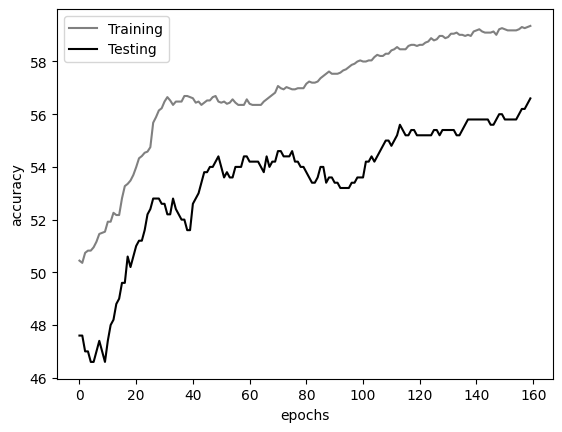

In [9]:
plt.plot(list(range(epochs)), axs, color='grey')
plt.plot(list(range(epochs)), axt, color='black')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Training', 'Testing'])

Text(0.5, 0, 'epochs')

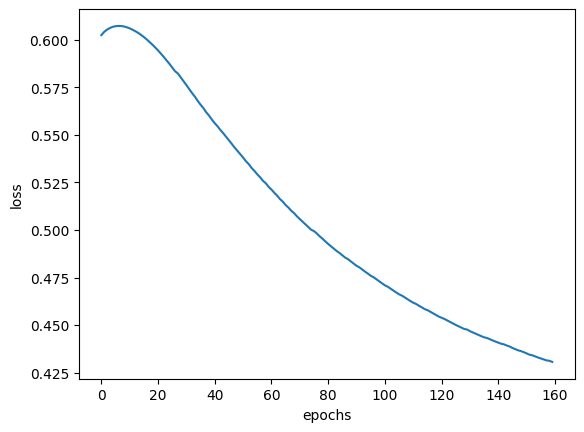

In [10]:
plt.plot(list(range(epochs)), loss)
plt.ylabel('loss')
plt.xlabel('epochs')

# Predicting the result (Dec, Sub or KO)

In [11]:
torch.manual_seed(random_state)

nn_result = NN(
    input_size=input_size,
    hidden_size=32,
    output_size=3,
)

yt = torch.tensor(Ytest['result'].to_numpy())
ys = torch.tensor(Ytrain['result'].to_numpy())

ds = MMADataset(xs, ys)
dl = DataLoader(ds, batch_size=32, shuffle=False)

epochs    = 7
lossfunc  = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_result.parameters(), lr=0.0001, weight_decay=0.001)

loss, axs, axt = train(nn_result, epochs, lossfunc, optimizer, dl, (xt, yt), print_interval=1)

Epoch [1/7], Loss: 1.1818, Training: 33.01%, Testing: 36.80%
Epoch [2/7], Loss: 1.1953, Training: 35.04%, Testing: 37.00%
Epoch [3/7], Loss: 1.2083, Training: 36.98%, Testing: 39.60%
Epoch [4/7], Loss: 1.2216, Training: 41.62%, Testing: 42.40%
Epoch [5/7], Loss: 1.2361, Training: 46.14%, Testing: 42.40%
Epoch [6/7], Loss: 1.2513, Training: 48.80%, Testing: 43.60%
Epoch [7/7], Loss: 1.2685, Training: 49.60%, Testing: 44.00%


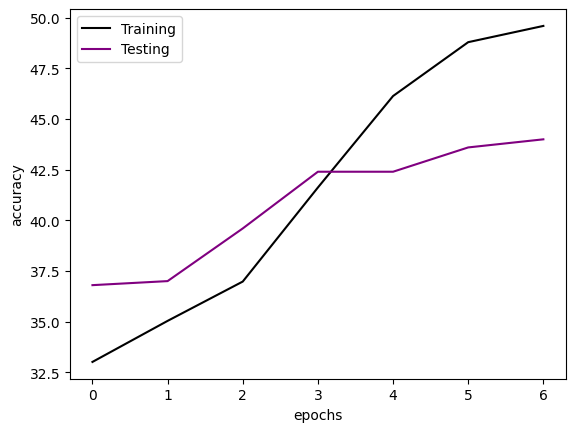

In [12]:
plt.plot(list(range(epochs)), axs, color='black')
plt.plot(list(range(epochs)), axt, color='purple')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Training', 'Testing'])

# Predicting the round (1, 2 or 3)

In [13]:
torch.manual_seed(random_state)

nn_round = NN(
    input_size=input_size,
    hidden_size=100,
    output_size=3,
)

yt = torch.tensor(Ytest['finish_round'].to_numpy())
ys = torch.tensor(Ytrain['finish_round'].to_numpy())

ds = MMADataset(xs, ys)
dl = DataLoader(ds, batch_size=64, shuffle=False)

epochs = 2
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_round.parameters(), lr=0.0001, weight_decay=0.01)

loss, axs, axt = train(nn_round, epochs, lossfunc, optimizer, dl, (xt, yt), print_interval=1)

Epoch [1/2], Loss: 1.0692, Training: 46.69%, Testing: 42.60%
Epoch [2/2], Loss: 1.0826, Training: 55.85%, Testing: 51.60%


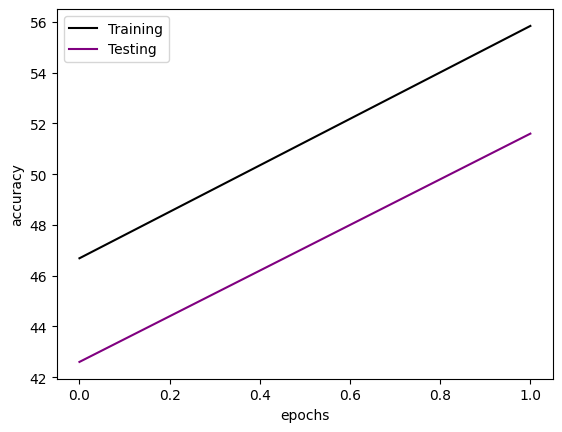

In [14]:
plt.plot(list(range(epochs)), axs, color='black')
plt.plot(list(range(epochs)), axt, color='purple')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Training', 'Testing']); None

# Eval

In [104]:
def brier_score(targets, probas):
    result = 0.0
    for row, y in zip(probas, targets):
        result += sum([(p - (1 if i == y else 0))**2 for i, p in enumerate(row)])
    return result / len(targets)

In [105]:
probas_winner = nn_winner(xt).detach().numpy()
preds_winner = probas_winner.argmax(1)

probas_round  = nn_round(xt).detach().numpy()
preds_round = probas_round.argmax(1)

probas_result = nn_result(xt).detach().numpy()
preds_result = probas_result.argmax(1)

print('\nAccuracies:')
print(accuracy_score(Ytest['winner'], preds_winner)*100)
print(accuracy_score(Ytest['result'], preds_result)*100)
print(accuracy_score(Ytest['finish_round'], preds_round)*100)

print('\nF1:')
print(f1_score(Ytest['winner'], preds_winner))
print(f1_score(Ytest['result'], preds_result, average='weighted'))
print(f1_score(Ytest['finish_round'], preds_round, average='weighted'))

print('\nLog-Losses:')

print(log_loss(Ytest['winner'], probas_winner))
print(log_loss(Ytest['result'], probas_result))
print(log_loss(Ytest['finish_round'], probas_round))

print('\nBrier-Scores:')

print(brier_score(Ytest['winner'], probas_winner))
print(brier_score(Ytest['result'], probas_result))
print(brier_score(Ytest['finish_round'], probas_round))


Accuracies:
56.599999999999994
44.0
51.6

F1:
0.581888246628131
0.30583925233644854
0.3923538496071829

Log-Losses:
0.7213216667544406
1.0570442203994757
1.0751282772893835

Brier-Scores:
0.5136920764373212
0.6413546113383304
0.6477571362696665
